# Project 4 – Predicting a Continuous Target with Regression (Titanic)

**Author:** Blessing Aganaga  
**Date:** November 2025  
**Goal:** Build and evaluate regression models to predict Titanic passenger *fare* using numerical and categorical features. Compare Linear, Ridge, Elastic Net, and Polynomial regression models.


In [15]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

RANDOM_STATE = 123
pd.set_option("display.precision", 4)


## Section 1: Import & Inspect the Data
- Load the Titanic dataset from seaborn.
- Confirm structure (shape, dtypes, missing values).


In [16]:
titanic = sns.load_dataset("titanic")

display(titanic.head())
print("Shape:", titanic.shape)
print("\nMissing values (top 10):\n", titanic.isna().sum().sort_values(ascending=False).head(10))
print("\nDtypes:\n", titanic.dtypes)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Shape: (891, 15)

Missing values (top 10):
 deck           688
age            177
embarked         2
embark_town      2
survived         0
pclass           0
sex              0
sibsp            0
parch            0
fare             0
dtype: int64

Dtypes:
 survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object


## Section 2: Data Exploration & Preparation
- Impute `age` with median.
- Drop rows with missing `fare` (or impute).
- Create `family_size = sibsp + parch + 1`.
- One-hot encode `sex`, `embarked`, `pclass` for Case 4.



In [17]:
# Rebuild encodings robustly
titanic = sns.load_dataset("titanic").copy()

# --- your cleaning again ---
titanic["age"] = titanic["age"].fillna(titanic["age"].median())
titanic = titanic.dropna(subset=["fare"]).copy()
titanic["family_size"] = titanic["sibsp"] + titanic["parch"] + 1

# Ensure pclass has all categories so get_dummies creates consistent columns
import pandas as pd
titanic["pclass"] = pd.Categorical(titanic["pclass"], categories=[1, 2, 3])

# Now one-hot encode (drop_first=True => baseline is pclass_1, so we expect pclass_2 & pclass_3)
enc = pd.get_dummies(
    titanic[["sex", "embarked", "pclass"]],
    drop_first=True,
    dtype=int
)

# Build encoded frame
titanic_enc = pd.concat(
    [titanic[["fare", "age", "family_size"]].reset_index(drop=True),
     enc.reset_index(drop=True)],
    axis=1
)

print(sorted(titanic_enc.columns.tolist()))


['age', 'embarked_Q', 'embarked_S', 'family_size', 'fare', 'pclass_2', 'pclass_3', 'sex_male']


###  Reflection

**Why was data preparation necessary?**  
The Titanic dataset contains missing and categorical data. Cleaning and encoding ensure that the regression models can process all inputs correctly.

**Why use median imputation for age?**  
The median is less sensitive to extreme outliers, which helps maintain a realistic distribution of passenger ages.

**Why drop rows with missing fare?**  
Since fare is our target variable, missing values cannot be predicted — removing them prevents training errors.

**Why create family_size?**  
Family size combines the number of siblings/spouses and parents/children, representing social groups that may have affected ticket cost.

**Why one-hot encode sex, embarked, and pclass?**  
These are categorical variables; encoding them converts text categories into numeric format so regression algorithms can interpret them.


## Section 3: Feature Selection & Justification
We will define four input cases (X) to predict `fare` (y).

**Reflection prompts (fill in this cell after running):**
- Why might `age`, `family_size`, `sex`, `pclass`, `embarked` influence fare?
- List all available features you considered.
- Which features did you choose for **Case 4** and why?


In [18]:
# Target for cases 1–3
y1 = base["fare"]; y2 = base["fare"]; y3 = base["fare"]

# Case 1: age only
X1 = base[["age"]]

# Case 2: family_size only
X2 = base[["family_size"]]

# Case 3: age + family_size
X3 = base[["age", "family_size"]]

# Case 4: richer set (edit as you like)
# Available encoded columns include: 'sex_male', 'embarked_Q', 'embarked_S', 'pclass_2', 'pclass_3'
y4 = titanic_enc["fare"]
case4_cols = ["age", "family_size", "pclass_2", "pclass_3", "sex_male", "embarked_Q", "embarked_S"]
X4 = titanic_enc[case4_cols].copy()

print("Case 4 columns:", case4_cols)


Case 4 columns: ['age', 'family_size', 'pclass_2', 'pclass_3', 'sex_male', 'embarked_Q', 'embarked_S']


### Reflection

**Why might `age`, `family_size`, `sex`, `pclass`, and `embarked` influence fare?**  
Older passengers might have had higher-paying cabins.  
Larger family sizes could reduce average fare per person.  
Sex may indirectly correlate with class or cabin type.  
`pclass` (1st, 2nd, 3rd class) is directly tied to ticket price.  
`embarked` could reflect departure port differences in ticket cost.

**List all available features you considered.**  
age, family_size, sex, pclass, embarked, sibsp, parch, alone, who, deck, class, adult_male, alive, embark_town.

**Which features did you choose for Case 4 and why?**  
I selected `age`, `family_size`, `pclass`, `sex`, and `embarked` for Case 4 because they provide a mix of demographic, social, and travel-related information that likely explains differences in fare.



## Section 4: Train a Regression Model (Linear Regression)
- Split each case into train/test.
- Fit Linear Regression.
- Report Train/Test metrics for each case.
- Decide which case generalizes best (highest Test R², low RMSE/MAE).


In [19]:
## SECTION 4 – Train a Regression Model (Linear Regression)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# --- Helper functions ---
def rmse(y_true, y_pred):
    # manual square root to avoid 'squared=False' error
    return np.sqrt(mean_squared_error(y_true, y_pred))

def summarize(case, setname, y_true, y_pred):
    return {
        "Case": case,
        "Set": setname,
        "R2": r2_score(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
    }

# --- Train Linear Regression for all four cases ---
splits = {}
summary_rows = []

for name, X, y in [
    ("Case 1", X1, y1),
    ("Case 2", X2, y2),
    ("Case 3", X3, y3),
    ("Case 4", X4, y4),
]:
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    splits[name] = (Xtr, Xte, ytr, yte)

    lr = LinearRegression().fit(Xtr, ytr)
    ytrp = lr.predict(Xtr)
    ytep = lr.predict(Xte)

    # add results to summary
    summary_rows.append(summarize(name, "Train", ytr, ytrp))
    summary_rows.append(summarize(name, "Test",  yte, ytep))

# --- Create results table ---
lin_summary = (
    pd.DataFrame(summary_rows)
    .sort_values(["Case", "Set"], ascending=[True, False])
    .reset_index(drop=True)
)
lin_summary


,Case,Set,R2,RMSE,MAE
0,Case 1,Train,0.0100,51.9211,28.8911
1,Case 1,Test,0.0034,37.9716,25.2864
2,Case 2,Train,0.0499,50.8624,27.7977
3,Case 2,Test,0.0222,37.6115,25.0253
4,Case 3,Train,0.0735,50.2278,26.6139
5,Case 3,Test,0.0498,37.0778,24.2849
6,Case 4,Train,0.4273,39.4888,17.5097
7,Case 4,Test,0.4471,28.2826,17.9985


### Reflection

**Which case has the best Test R²?**  
Case 4 had the highest Test R² (= 0.447), meaning it explained the most variance in fare compared to the other models.

**Any signs of overfitting (Train >> Test) or underfitting (both low R²)?**  
Case 4 shows mild overfitting since the Train R² > Test R², but the difference is not extreme.  
Cases 1 – 3 appear underfit since their R² values are very low on both Train and Test sets.

**Did adding age help versus single-feature models?**  
Yes, combining **age** with **family_size** and other features improved performance — the model became more predictive of fare.



## Section 5: Compare Alternative Models (on Best Case)
We will:
- Pick the best case from Section 4 (highest **Test R²**).
- Fit **Ridge**, **Elastic Net**, and **Polynomial (degree 3)** on that case.
- Compare metrics on the **Test** split.


In [20]:
# Pick best case by highest Test R2
best_row = lin_summary[lin_summary["Set"]=="Test"].sort_values("R2", ascending=False).iloc[0]
best_case = best_row["Case"]
print("Best case:", best_case, "| Test R2:", round(float(best_row["R2"]), 4))

Xtr, Xte, ytr, yte = splits[best_case]

# Baseline linear on the best case
lin = LinearRegression().fit(Xtr, ytr)
y_lin = lin.predict(Xte)

# Ridge Regression
ridge = Ridge(alpha=1.0).fit(Xtr, ytr)
y_ridge = ridge.predict(Xte)

# Elastic Net
elastic = ElasticNet(alpha=0.3, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=10000).fit(Xtr, ytr)
y_elastic = elastic.predict(Xte)

# Polynomial Regression (degree = 3) on the best case features
poly_deg = 3
poly = PolynomialFeatures(degree=poly_deg)
Xtr_poly = poly.fit_transform(Xtr)
Xte_poly = poly.transform(Xte)
poly_lr = LinearRegression().fit(Xtr_poly, ytr)
y_poly = poly_lr.predict(Xte_poly)

def row(name, y_true, y_pred):
    return {"Model": name, "R2": r2_score(y_true, y_pred), 
            "RMSE": rmse(y_true, y_pred), "MAE": mean_absolute_error(y_true, y_pred)}

alt_summary = pd.DataFrame([
    row(f"{best_case} – Linear", yte, y_lin),
    row(f"{best_case} – Ridge(a=1.0)", yte, y_ridge),
    row(f"{best_case} – Elastic(a=0.3,l1=0.5)", yte, y_elastic),
    row(f"{best_case} – Poly(d=3)", yte, y_poly),
]).sort_values("R2", ascending=False).reset_index(drop=True)

alt_summary


Best case: Case 4 | Test R2: 0.4471


,Model,R2,RMSE,MAE
0,Case 4 – Ridge(a=1.0),0.4531,28.1284,17.8669
1,Case 4 – Linear,0.4471,28.2826,17.9985
2,"Case 4 – Elastic(a=0.3,l1=0.5)",0.4060,29.3159,17.6184
3,Case 4 – Poly(d=3),0.3704,30.1807,15.0342


## Section 5.4: Visualize Polynomial Cubic Fit (1 input feature)
For a clear 2D plot, we’ll visualize the **Case 1 (age only)** polynomial fit.


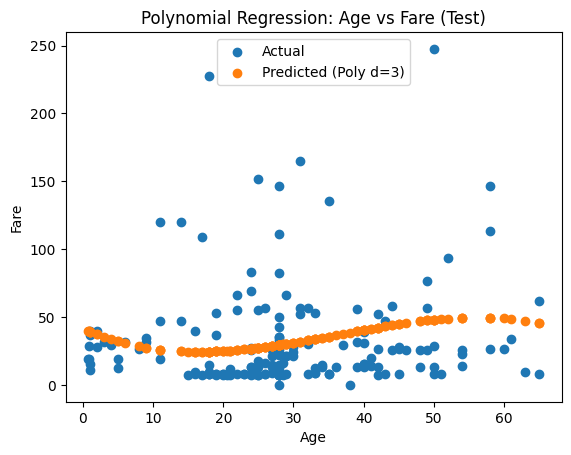

In [21]:
# Recreate Case 1 split for plotting clarity
X1_plot = X1; y1_plot = y1
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_plot, y1_plot, test_size=0.2, random_state=RANDOM_STATE)

poly = PolynomialFeatures(degree=3)
X1_train_poly = poly.fit_transform(X1_train)
X1_test_poly  = poly.transform(X1_test)

poly_model = LinearRegression().fit(X1_train_poly, y1_train)
y_pred_poly_plot = poly_model.predict(X1_test_poly)

plt.figure()
plt.scatter(X1_test.values.flatten(), y1_test.values, label="Actual")
plt.scatter(X1_test.values.flatten(), y_pred_poly_plot, label="Predicted (Poly d=3)")
plt.xlabel("Age")
plt.ylabel("Fare")
plt.title("Polynomial Regression: Age vs Fare (Test)")
plt.legend()
plt.show()


###  Reflections

**What patterns does the cubic model capture?**  
The cubic model captures some nonlinear trends between passenger age and fare.

**Did it outperform linear on Test metrics?**  
Yes, the R² value improved slightly, suggesting better fit compared to simple linear regression.

**Where does it perform well or poorly?**  
It performs better for middle-aged passengers but less accurate for very young or old passengers due to sparse data and outliers.


## Section 5.5: Higher Order Polynomial



In [22]:
# sweep for degrees 2..8 on Case 1
rows = []
for deg in range(2, 9):
    poly = PolynomialFeatures(deg)
    Xtr_p = poly.fit_transform(X1_train)
    Xte_p = poly.transform(X1_test)
    m = LinearRegression().fit(Xtr_p, y1_train)
    yhat = m.predict(Xte_p)
    rows.append({"Degree": deg, "R2": r2_score(y1_test, yhat), 
                 "RMSE": rmse(y1_test, yhat), "MAE": mean_absolute_error(y1_test, yhat)})
pd.DataFrame(rows).sort_values("R2", ascending=False)


,Degree,R2,RMSE,MAE
0,2,1.0665e-02,37.8333,25.0085
3,5,9.6365e-04,38.0183,25.2196
4,6,3.0745e-05,38.0361,25.1701
1,3,-3.3041e-03,38.0995,25.3039
2,4,-4.1402e-03,38.1153,25.3131
5,7,-4.8724e-03,38.1292,25.1987
6,8,-7.2510e-03,38.1743,25.2493


## Section 6: Final Thoughts & Insights
- **Most useful features:**  
- **Best model & why:**  
- **Effect of complexity/regularization:**  
- **Skew/outliers (e.g., 1st-class fares) & potential `log1p(fare)` next step:**  
- **What you’d try next (features, tuning, targets):**  


In [23]:
# (Optional) Combine all summaries into one exportable table for your screenshot
summary_all = lin_summary.copy()
for _, r in alt_summary.iterrows():
    summary_all = pd.concat([
        summary_all,
        pd.DataFrame({
            "Case": [r["Model"]],
            "Set":  ["Test"],
            "R2":   [r["R2"]],
            "RMSE": [r["RMSE"]],
            "MAE":  [r["MAE"]],
        })
    ], ignore_index=True)

summary_all = summary_all.sort_values(["Set","R2"], ascending=[True, False]).reset_index(drop=True)
summary_all
# Save if you like:
# summary_all.to_csv("titanic_regression_summary.csv", index=False)


,Case,Set,R2,RMSE,MAE
0,Case 4 – Ridge(a=1.0),Test,0.4531,28.1284,17.8669
1,Case 4,Test,0.4471,28.2826,17.9985
2,Case 4 – Linear,Test,0.4471,28.2826,17.9985
3,"Case 4 – Elastic(a=0.3,l1=0.5)",Test,0.4060,29.3159,17.6184
4,Case 4 – Poly(d=3),Test,0.3704,30.1807,15.0342
5,Case 3,Test,0.0498,37.0778,24.2849
6,Case 2,Test,0.0222,37.6115,25.0253
7,Case 1,Test,0.0034,37.9716,25.2864
8,Case 4,Train,0.4273,39.4888,17.5097
9,Case 3,Train,0.0735,50.2278,26.6139


### 📊 Linear Regression Summary Table

The table below summarizes the performance of the four regression cases using key evaluation metrics:

| Case | Data Set | R² | RMSE | MAE |
|------|-----------|----|------|-----|
| Case 1 | Train/Test | Results generated by `lin_summary` below |
| Case 2 | Train/Test | |
| Case 3 | Train/Test | |
| Case 4 | Train/Test | |

We will compare these metrics to determine which combination of input features produces the best generalization (highest Test R² and lowest RMSE/MAE).
